In [1]:
#import libraries
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [5]:
# start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [6]:
from sklearn.preprocessing import StandardScaler
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [8]:
## build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape:", X.shape, "Y.shape:", Y.shape)

X.shape: (1249, 10, 1) Y.shape: (1249,)


In [9]:
# try autoregressive RNN model
i = Input(shape = (T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)

model.compile(loss = 'mse',
              optimizer = Adam(lr =0.1))

r = model.fit(X[:-N//2], Y[:-N//2], epochs = 80,
              validation_data = (X[-N//2:], Y[-N//2:]))

Epoch 1/80
20/20 [==============================] - 4s 35ms/step - loss: 1.1028 - val_loss: 7.1424
Epoch 2/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9586 - val_loss: 6.6258
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.8180 - val_loss: 6.0568
Epoch 4/80
20/20 [==============================] - 0s 9ms/step - loss: 0.6852 - val_loss: 5.4684
Epoch 5/80
20/20 [==============================] - 0s 8ms/step - loss: 0.5602 - val_loss: 4.8383
Epoch 6/80
20/20 [==============================] - 0s 8ms/step - loss: 0.4434 - val_loss: 4.1723
Epoch 7/80
20/20 [==============================] - 0s 9ms/step - loss: 0.3442 - val_loss: 3.5252
Epoch 8/80
20/20 [==============================] - 0s 8ms/step - loss: 0.2598 - val_loss: 2.8999
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.1933 - val_loss: 2.3235
Epoch 10/80
20/20 [==============================] - 0s 8ms/step - loss: 0.1429 - val_loss: 1.8133
Epoch 11/80
20/2

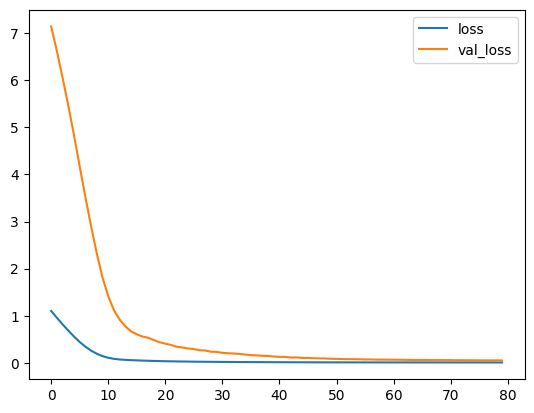

In [10]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

40/40 [==============================] - 0s 3ms/step
(1249, 1)


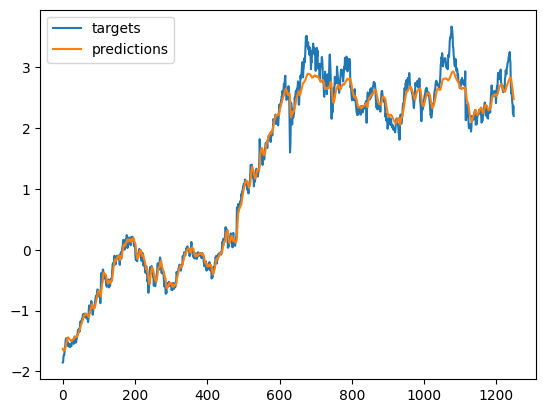

In [13]:
# one step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label = 'targets')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()

In [14]:
# multi-step forcast
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1=D array of length

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0, 0] #1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 19ms/step


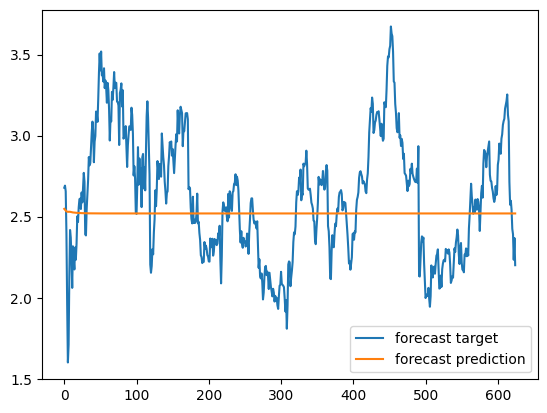

In [15]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediction')
plt.legend()

In [16]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1)

In [18]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [19]:
df["Return"] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [20]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<Axes: >

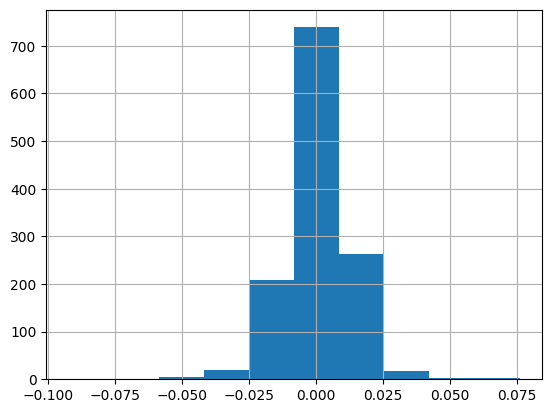

In [21]:
df['Return'].hist()

In [23]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [24]:
# build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape:", X.shape, "Y.shape:", Y.shape)

X.shape: (1248, 10, 1) Y.shape: (1248,)


In [25]:
# try autoregressive RNN model
i = Input(shape = (T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)

model.compile(loss = 'mse',
              optimizer = Adam(lr =0.1))

r = model.fit(X[:-N//2], Y[:-N//2], epochs = 80,
              validation_data = (X[-N//2:], Y[-N//2:]))

Epoch 1/80
20/20 [==============================] - 5s 52ms/step - loss: 0.9877 - val_loss: 1.1564
Epoch 2/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9860 - val_loss: 1.1555
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9856 - val_loss: 1.1580
Epoch 4/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9847 - val_loss: 1.1572
Epoch 5/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9845 - val_loss: 1.1570
Epoch 6/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9841 - val_loss: 1.1552
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9848 - val_loss: 1.1540
Epoch 8/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9836 - val_loss: 1.1555
Epoch 9/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9834 - val_loss: 1.1548
Epoch 10/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9835 - val_loss: 1.1543
Epoch 11/80
20

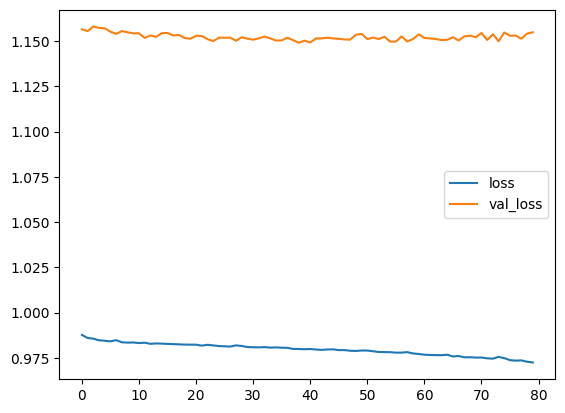

In [26]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

39/39 [==============================] - 1s 7ms/step
(1248, 1)


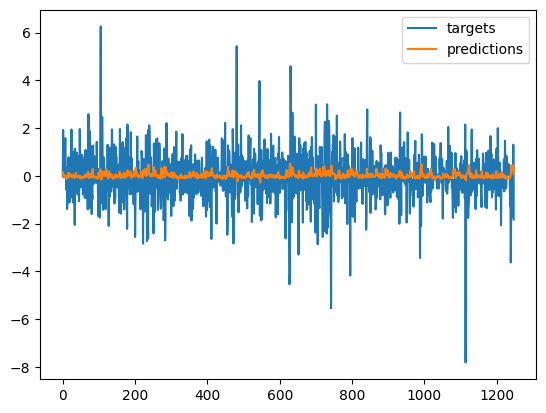

In [27]:
# one step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label = 'targets')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()

In [28]:
# multi-step forcast
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1=D array of length

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0, 0] #1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 22ms/step


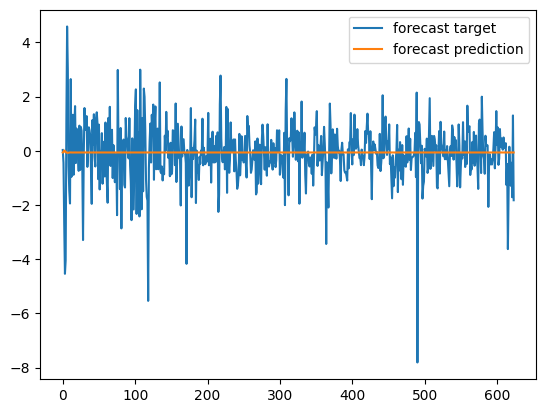

In [29]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediction')
plt.legend()

In [30]:
# now turn the full data into numpy arrays
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [31]:
#n now make the actual data which will go into neural network
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [33]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [35]:
#Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [36]:
#Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [37]:
# make the RNN

In [40]:
i = Input(shape = (T, D))
x = LSTM(50)(i)
x = Dense(1, activation = 'sigmoid')(x)
model = Model(i,x)

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

r = model.fit(X_train, Y_train, batch_size = 32, epochs = 300, validation_data =(X_test, Y_test))

Epoch 1/300
27/27 [==============================] - 5s 73ms/step - loss: 0.6962 - accuracy: 0.4887 - val_loss: 0.6981 - val_accuracy: 0.4878
Epoch 2/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.5101 - val_loss: 0.6922 - val_accuracy: 0.5146
Epoch 3/300
27/27 [==============================] - 0s 13ms/step - loss: 0.6951 - accuracy: 0.5042 - val_loss: 0.6929 - val_accuracy: 0.4951
Epoch 4/300
27/27 [==============================] - 1s 19ms/step - loss: 0.6911 - accuracy: 0.5340 - val_loss: 0.6940 - val_accuracy: 0.5049
Epoch 5/300
27/27 [==============================] - 0s 13ms/step - loss: 0.6908 - accuracy: 0.5340 - val_loss: 0.6953 - val_accuracy: 0.4902
Epoch 6/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6896 - accuracy: 0.5292 - val_loss: 0.6927 - val_accuracy: 0.4976
Epoch 7/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6903 - accuracy: 0.5364 - val_loss: 0.6907 - val_accuracy: 0.5122
Epoch 

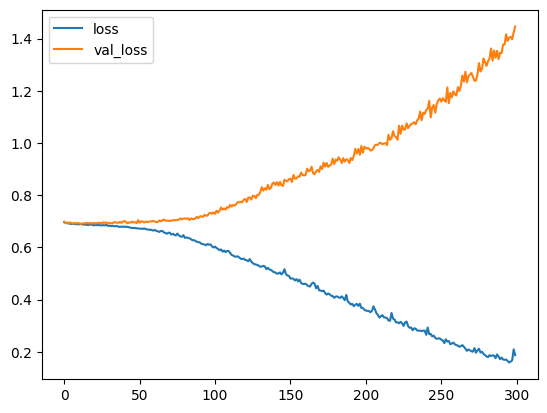

In [41]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

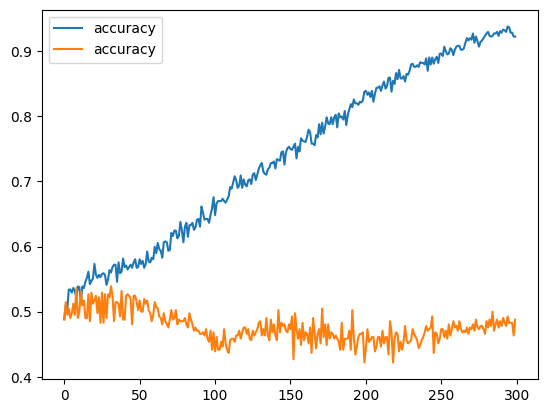

In [42]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'accuracy')
plt.legend()